# Ocean Current
Ocean current consist of geostrophic and Ekman currents. Geostrophic current is the result of balance between the pressure gradient force and the Coriolis effect. Ekman current or wind-driven current is the net movement of water when the Coriolis force is balanced by the turbulent drag forces. 

Following Geng et al. (2024), these currents can be estimated individually from sea surface height and wind stress. 

- Zonal geostrophic current 
$$u_{g} = \frac{g}{\beta} \frac{\partial^2 h}{\partial y^2}$$

where $g$ is the gravitational acceleration, $\beta$ is the Rossby parameter, $h$ is the sea level anomaly, and $y$ is the meridional distance.

- Zonal Ekman current
$$u_{e} = \frac{1}{\rho H} \frac{r_{s}\tau_x + f \tau_y}{r_{s}^2+f^2}$$

where $\rho$ is the density of seawater, $H$ is the mixed layer depth, $\tau_x$ and $\tau_y$ are the zonal and meridional wind stress anomalies, $f$ is the Coriolis parameter ($\beta y$), and $r_s = (1/2)\; \text{day}^{-1}$ is the dissipation rate.

# Calculate the Ekman current

In [1]:
# Load the wind stress data
import xarray as xr 

ds = xr.open_dataset(r"wind_stress.1994_2025.ERA5.nc")
ds = ds.rename({'latitude':'lat', 'longitude':'lon'})

In [2]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:                     (time: 367, lat: 80, lon: 640)
Coordinates:
  * lat                         (lat) float32 320B -9.875 -9.625 ... 9.625 9.875
  * time                        (time) datetime64[ns] 3kB 1994-07-01 ... 2025...
  * lon                         (lon) float32 3kB 120.1 120.4 ... 279.6 279.9
Data variables:
    eastward_stress             (time, lat, lon) float64 150MB ...
    eastward_stress_bias        (time, lat, lon) float64 150MB ...
    eastward_stress_sdd         (time, lat, lon) float64 150MB ...
    northward_stress            (time, lat, lon) float64 150MB ...
    northward_stress_bias       (time, lat, lon) float64 150MB ...
    northward_stress_sdd        (time, lat, lon) float64 150MB ...
    wind_stress_magnitude       (time, lat, lon) float64 150MB ...
    wind_stress_magnitude_bias  (time, lat, lon) float64 150MB ...
    wind_stress_magnitude_sdd   (time, lat, lon) float64 150MB ...
Attributes:
    title:                      Global Ocean - Wind and Stress - Monthly - Fr...
    references:                Copernicus Marine Service Product User Manual ...
    Conventions:               CF-1.6, ACDD-1.3
    institution:               Royal Netherlands Meteorological Institute (KNMI)
    history:                   N/A
    copernicusmarine_version:  2.1.2

In [3]:
# Select the time period 
daily = ds.sel(time=slice('2023-01', '2024-12'))

clim  = ds.sel(time=slice('1994-01', '2020-12')).mean(dim='time')

# Calculate the anomalies
anom  = daily - clim

In [4]:
anom = anom.rename({
    'eastward_stress': 'tau_x',
    'northward_stress': 'tau_y',
})

In [5]:
import numpy as np
import xarray as xr

def calculate_ekman_current(tau_x, tau_y, lat, mixed_layer_depth=50.0, 
                           dissipation_rate=0.5, seawater_density=1025.0):
    """
    Calculate Ekman current from wind stress anomalies.
    
    Parameters:
    -----------
    tau_x : array-like
        Zonal wind stress anomaly (N/m²)
    tau_y : array-like  
        Meridional wind stress anomaly (N/m²)
    lat : array-like
        Latitude values (degrees)
    mixed_layer_depth : float
        Mixed layer depth H (m), default 50 m
    dissipation_rate : float
        Dissipation rate rs (1/day), default 0.5 day⁻¹
    seawater_density : float
        Density of seawater ρ (kg/m³), default 1025 kg/m³
        
    Returns:
    --------
    u_e : array-like
        Ekman current velocity (m/s)
    """
    
    # Physical constants
    omega = 7.2921e-5  # Earth's angular velocity (rad/s)
    
    # Convert inputs to numpy arrays if needed
    tau_x = np.asarray(tau_x)
    tau_y = np.asarray(tau_y)
    lat = np.asarray(lat)
    
    # Convert latitude to radians for Coriolis parameter calculation
    lat_rad = np.deg2rad(lat)
    
    # Calculate Coriolis parameter: f = 2 * omega * sin(lat)
    f = 2 * omega * np.sin(lat_rad)
    
    # Handle near-equatorial regions where f approaches zero
    # Set minimum |f| to avoid division by zero
    f_min = 1e-6  # Minimum Coriolis parameter
    f = np.where(np.abs(f) < f_min, np.sign(f) * f_min, f)
    
    # Convert dissipation rate from day⁻¹ to s⁻¹
    rs_per_second = dissipation_rate / (24 * 3600)  # Convert day⁻¹ to s⁻¹
    
    # Calculate denominator: ρH(rs² + f²)
    denominator = seawater_density * mixed_layer_depth * (rs_per_second**2 + f**2)
    
    # Calculate numerator: rs*τˣ + f*τʸ
    numerator = rs_per_second * tau_x + f * tau_y
    
    # Calculate Ekman current: ue = (1/(ρH)) * (rs*τˣ + f*τʸ)/(rs² + f²)
    u_e = numerator / denominator
    
    return u_e

def calculate_ekman_current_components(tau_x, tau_y, lat, mixed_layer_depth=50.0,
                                     dissipation_rate=0.5, seawater_density=1025.0):
    """
    Calculate both components of Ekman current (eastward and northward).
    
    The full Ekman current equations are:
    u_e = (1/(ρH)) * (rs*τˣ + f*τʸ)/(rs² + f²)  [eastward component]
    v_e = (1/(ρH)) * (rs*τʸ - f*τˣ)/(rs² + f²)  [northward component]
    
    Parameters:
    -----------
    tau_x : array-like
        Zonal wind stress anomaly (N/m²)
    tau_y : array-like
        Meridional wind stress anomaly (N/m²)
    lat : array-like
        Latitude values (degrees)
    mixed_layer_depth : float
        Mixed layer depth H (m), default 50 m
    dissipation_rate : float
        Dissipation rate rs (1/day), default 0.5 day⁻¹
    seawater_density : float
        Density of seawater ρ (kg/m³), default 1025 kg/m³
        
    Returns:
    --------
    u_e : array-like
        Eastward Ekman current velocity (m/s)
    v_e : array-like
        Northward Ekman current velocity (m/s)
    """
    
    # Physical constants
    omega = 7.2921e-5  # Earth's angular velocity (rad/s)
    
    # Convert inputs to numpy arrays if needed
    tau_x = np.asarray(tau_x)
    tau_y = np.asarray(tau_y)
    lat = np.asarray(lat)
    
    # Convert latitude to radians
    lat_rad = np.deg2rad(lat)
    
    # Calculate Coriolis parameter
    f = 2 * omega * np.sin(lat_rad)
    
    # Handle near-equatorial regions
    f_min = 1e-6
    f = np.where(np.abs(f) < f_min, np.sign(f) * f_min, f)
    
    # Convert dissipation rate from day⁻¹ to s⁻¹
    rs_per_second = dissipation_rate / (24 * 3600)
    
    # Calculate denominator
    denominator = seawater_density * mixed_layer_depth * (rs_per_second**2 + f**2)
    
    # Calculate Ekman current components
    u_e = (rs_per_second * tau_x + f * tau_y) / denominator  # Eastward
    v_e = (rs_per_second * tau_y - f * tau_x) / denominator  # Northward
    
    return u_e, v_e

def ekman_current_from_xarray(wind_stress_data, tau_x_var='tau_x', tau_y_var='tau_y',
                             lat_coord='lat', **kwargs):
    """
    Calculate Ekman current from xarray Dataset containing wind stress data.
    
    Parameters:
    -----------
    wind_stress_data : xarray.Dataset or xarray.DataArray
        Dataset containing wind stress anomaly data
    tau_x_var : str
        Variable name for zonal wind stress (default: 'tau_x')
    tau_y_var : str
        Variable name for meridional wind stress (default: 'tau_y')
    lat_coord : str
        Coordinate name for latitude (default: 'lat')
    **kwargs : dict
        Additional parameters for calculate_ekman_current_components
        
    Returns:
    --------
    ekman_currents : xarray.Dataset
        Dataset containing u_e and v_e components
    """
    
    # Extract wind stress components and latitude
    if isinstance(wind_stress_data, xr.Dataset):
        tau_x = wind_stress_data[tau_x_var]
        tau_y = wind_stress_data[tau_y_var]
        lat = wind_stress_data[lat_coord]
    else:
        raise ValueError("Input must be xarray.Dataset")
    
    # Broadcast latitude to match wind stress dimensions if needed
    lat_broadcast = lat
    if tau_x.dims != lat.dims:
        # Find the latitude dimension in tau_x
        lat_dim_idx = tau_x.dims.index(lat_coord)
        # Create broadcasting shape
        broadcast_shape = [1] * len(tau_x.dims)
        broadcast_shape[lat_dim_idx] = len(lat)
        lat_broadcast = lat.values.reshape(broadcast_shape)
    
    # Calculate Ekman currents
    u_e, v_e = calculate_ekman_current_components(
        tau_x.values, tau_y.values, lat_broadcast, **kwargs
    )
    
    # Create output dataset
    ekman_currents = xr.Dataset({
        'u_e': xr.DataArray(
            u_e, 
            dims=tau_x.dims,
            coords=tau_x.coords,
            attrs={
                'long_name': 'Eastward Ekman Current',
                'units': 'm/s',
                'description': 'Calculated from wind stress anomalies'
            }
        ),
        'v_e': xr.DataArray(
            v_e,
            dims=tau_y.dims, 
            coords=tau_y.coords,
            attrs={
                'long_name': 'Northward Ekman Current',
                'units': 'm/s',
                'description': 'Calculated from wind stress anomalies'
            }
        )
    })
    
    return ekman_currents

# Example usage
def example_usage(data):
    """
    Example of how to use the Ekman current calculation
    """
    
    # Calculate Ekman currents
    ekman_data = ekman_current_from_xarray(
        data,
        mixed_layer_depth=50.0,  # 50 m
        dissipation_rate=0.5,    # 0.5 day⁻¹
        seawater_density=1025.0  # kg/m³
    )
    
    print(f"Wind stress shape: {data['tau_x'].shape}")
    print(f"Ekman current shape: {ekman_data['u_e'].shape}")
    print(f"Eastward velocity range: {ekman_data['u_e'].min().values:.6f} to {ekman_data['u_e'].max().values:.6f} m/s")
    print(f"Northward velocity range: {ekman_data['v_e'].min().values:.6f} to {ekman_data['v_e'].max().values:.6f} m/s")
    
    return ekman_data    

In [6]:
ue = example_usage(anom)

Wind stress shape: (24, 80, 640)
Ekman current shape: (24, 80, 640)
Eastward velocity range: -0.277458 to 0.307548 m/s
Northward velocity range: -0.265182 to 0.311054 m/s


In [7]:
ue

<xarray.Dataset> Size: 20MB
Dimensions:  (lat: 80, time: 24, lon: 640)
Coordinates:
  * lat      (lat) float32 320B -9.875 -9.625 -9.375 ... 9.375 9.625 9.875
  * time     (time) datetime64[ns] 192B 2023-01-01 2023-02-01 ... 2024-12-01
  * lon      (lon) float32 3kB 120.1 120.4 120.6 120.9 ... 279.4 279.6 279.9
Data variables:
    u_e      (time, lat, lon) float64 10MB nan nan nan ... -0.01544 -0.01532
    v_e      (time, lat, lon) float64 10MB nan nan nan ... 0.01048 0.01601

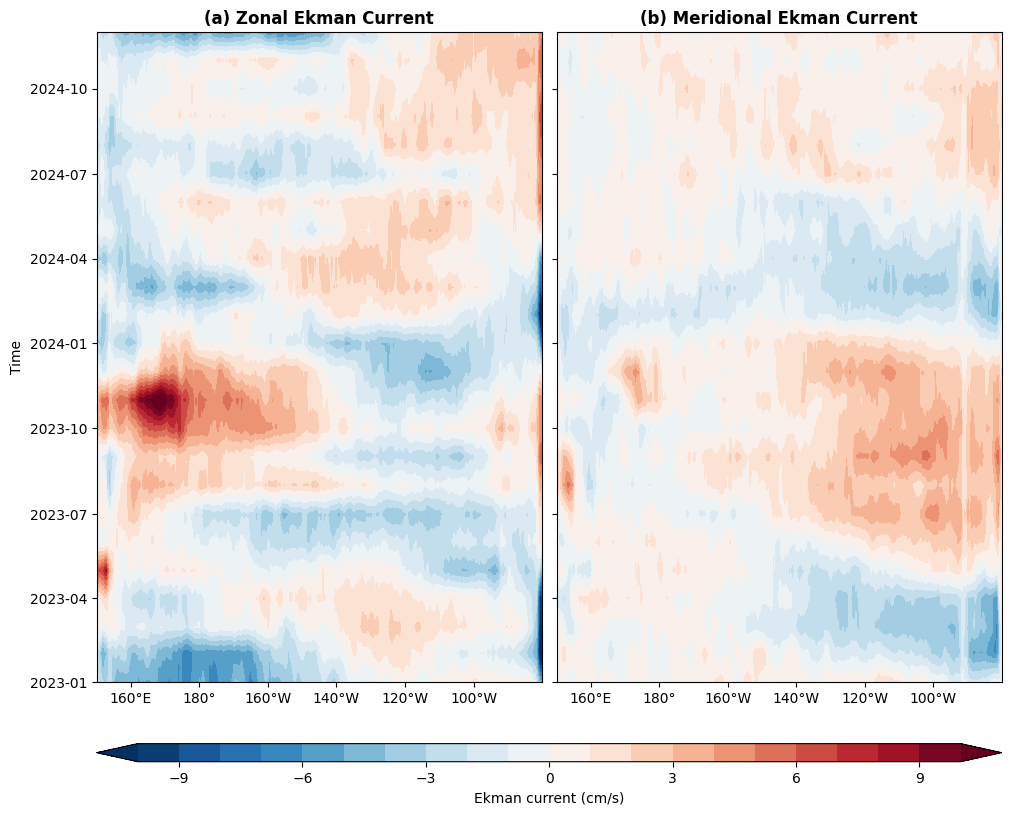

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter

lon_format = lambda v, _: f'{abs(v-360):.0f}°W' if v > 180 else (f'{v:.0f}°E' if v < 180 else '180°')

time = ue['time'].values
lons = ue['lon'].values

factor = 100 
limit = 0.1 * factor
norm = TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)

cbarticks = np.arange(-limit, limit+1, 1)
cargs = dict(cmap='RdBu_r', levels=cbarticks, norm=norm, extend='both')

fig, ax = plt.subplots(figsize=(10, 8), ncols=2, sharey=True, constrained_layout=True)

titles = ['(a) Zonal Ekman Current', '(b) Meridional Ekman Current']

for n, (year, data) in enumerate(ue.items()):
    hov = data.sel(lat=slice(-5,5), lon=slice(150,280)).mean(dim='lat') * factor 

    c = ax[n].contourf(hov.lon, time, hov, **cargs)
    ax[n].set_title(titles[n], fontweight='bold')
    ax[n].xaxis.set_major_formatter(FuncFormatter(lon_format))

cbar = fig.colorbar(c, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Ekman current (cm/s)', fontsize=10)
ax[0].set_ylabel('Time')

plt.show()

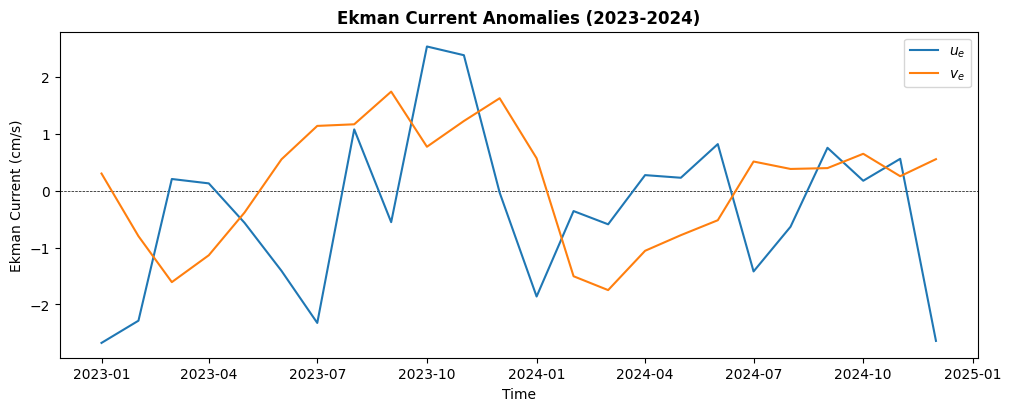

In [9]:
# Average Ekman current anomalies over the specified region

time = ue['time'].values
lons = ue['lon'].values

factor = 100 

colors = ['tab:blue', 'tab:orange']

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

titles = [r'$u_e$', r'$v_e$']

for n, (year, data) in enumerate(ue.items()):
    avg = data.sel(lat=slice(-5,5), lon=slice(150,270)).mean(['lat', 'lon']) * factor 

    ax.plot(time, avg, color=colors[n], label=titles[n])


ax.axhline(0, color='black', linestyle='--', linewidth=0.5, zorder=0)

ax.set_xlabel('Time')
ax.set_ylabel('Ekman Current (cm/s)')
ax.set_title('Ekman Current Anomalies (2023-2024)', fontweight='bold')

ax.legend()

plt.show()

# Calculate Geostrophic Current

In [10]:
# Load the dataset

import xarray as xr 


ds1 = xr.open_mfdataset([
    r"sshg.2023.nc", 
    r"sshg.2024.nc"
])

ds2 = xr.open_dataset(r"sshg.mon.ltm.1991-2020.nc")

C:\Users\binta\AppData\Local\Temp\ipykernel_50716\1144232268.py:11: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds2 = xr.open_dataset(r"sshg.mon.ltm.1991-2020.nc")
C:\Users\binta\AppData\Local\Temp\ipykernel_50716\1144232268.py:11: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  ds2 = xr.open_dataset(r"sshg.mon.ltm.1991-2020.nc")


In [11]:
daily = ds1['sshg']
clim  = ds2['sshg'].mean(dim='time')

# Calculate the anomalies
anom  = daily - clim

In [12]:
sla = anom.sel(lat=slice(-10, 10), lon=slice(120, 280))

In [13]:
sla

<xarray.DataArray 'sshg' (time: 24, lat: 60, lon: 160)> Size: 922kB
dask.array<getitem, shape=(24, 60, 160), dtype=float32, chunksize=(1, 60, 160), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 640B 120.5 121.5 122.5 123.5 ... 277.5 278.5 279.5
  * lat      (lat) float32 240B -9.834 -9.5 -9.167 -8.834 ... 9.166 9.499 9.833
  * time     (time) datetime64[ns] 192B 2023-01-01 2023-02-01 ... 2024-12-01

In [14]:
def calculate_geostrophic_velocity(ssh_data, lat_coord='lat', lon_coord='lon', time_coord='time'):
    """
    Calculate geostrophic velocity from SSH anomaly data.
    
    Parameters:
    -----------
    ssh_data : xarray.DataArray or numpy.ndarray
        SSH anomaly data with dimensions (time, lat, lon)
    lat_coord : str
        Name of latitude coordinate (default: 'lat')
    lon_coord : str  
        Name of longitude coordinate (default: 'lon')
    time_coord : str
        Name of time coordinate (default: 'time')
    
    Returns:
    --------
    u_g : xarray.DataArray
        Geostrophic velocity in x-direction (eastward)
    """
    
    # Physical constants
    g = 9.81  # gravitational acceleration (m/s^2)
    omega = 7.2921e-5  # Earth's angular velocity (rad/s)
    R_earth = 6.371e6  # Earth's radius (m)
    
    # If input is numpy array, convert to xarray for easier handling
    if isinstance(ssh_data, np.ndarray):
        # Assuming dimensions are (time, lat, lon)
        ssh_data = xr.DataArray(ssh_data, dims=[time_coord, lat_coord, lon_coord])
    
    # Get coordinates
    if isinstance(ssh_data, xr.DataArray):
        lat = ssh_data[lat_coord]
        lon = ssh_data[lon_coord]
    else:
        raise ValueError("Input must be xarray.DataArray or numpy.ndarray")
    
    # Convert latitude to radians for Coriolis parameter calculation
    lat_rad = np.deg2rad(lat)
    
    # Calculate Coriolis parameter (beta-plane approximation)
    # f = 2 * omega * sin(lat)
    # beta = df/dy = (2 * omega * cos(lat)) / R_earth
    f = 2 * omega * np.sin(lat_rad)
    beta = (2 * omega * np.cos(lat_rad)) / R_earth
    
    # Convert longitude to meters (approximate)
    # dy = R_earth * d(lat in radians)
    # dx = R_earth * cos(lat) * d(lon in radians)
    lat_spacing = np.deg2rad(np.abs(np.diff(lat).mean()))
    dy = R_earth * lat_spacing
    
    # Calculate d²h/dy² using centered finite differences
    # For interior points: d²h/dy² ≈ (h[i+1] - 2*h[i] + h[i-1]) / dy²
    h = ssh_data.values
    
    if len(h.shape) == 3:  # (time, lat, lon)
        d2h_dy2 = np.zeros_like(h)
        
        # Interior points (centered difference)
        d2h_dy2[:, 1:-1, :] = (h[:, 2:, :] - 2*h[:, 1:-1, :] + h[:, :-2, :]) / (dy**2)
        
        # Boundary conditions (forward/backward difference)
        # Forward difference at southern boundary
        d2h_dy2[:, 0, :] = (h[:, 2, :] - 2*h[:, 1, :] + h[:, 0, :]) / (dy**2)
        # Backward difference at northern boundary  
        d2h_dy2[:, -1, :] = (h[:, -1, :] - 2*h[:, -2, :] + h[:, -3, :]) / (dy**2)
        
    elif len(h.shape) == 2:  # (lat, lon) - single time step
        d2h_dy2 = np.zeros_like(h)
        
        # Interior points
        d2h_dy2[1:-1, :] = (h[2:, :] - 2*h[1:-1, :] + h[:-2, :]) / (dy**2)
        
        # Boundary conditions
        d2h_dy2[0, :] = (h[2, :] - 2*h[1, :] + h[0, :]) / (dy**2)
        d2h_dy2[-1, :] = (h[-1, :] - 2*h[-2, :] + h[-3, :]) / (dy**2)
    
    else:
        raise ValueError("SSH data must have 2 or 3 dimensions")
    
    # Calculate geostrophic velocity: u_g = -(g/β) * (d²h/dy²)
    # Beta needs to be broadcast to match data dimensions
    if len(h.shape) == 3:
        beta_broadcast = beta.values[np.newaxis, :, np.newaxis]  # (1, lat, 1)
    else:
        beta_broadcast = beta.values[:, np.newaxis]  # (lat, 1)
    
    u_g = -(g / beta_broadcast) * d2h_dy2
    
    # Convert back to xarray.DataArray with proper coordinates
    if isinstance(ssh_data, xr.DataArray):
        u_g = xr.DataArray(
            u_g,
            dims=ssh_data.dims,
            coords=ssh_data.coords,
            attrs={
                'long_name': 'Geostrophic velocity (eastward)',
                'units': 'm/s',
                'description': 'Calculated from SSH anomaly using u_g = -(g/β)(d²h/dy²)'
            }
        )
    
    return u_g

# Example usage:
def u_geostrophic(data):
    
    # Calculate geostrophic velocity
    ug = calculate_geostrophic_velocity(data.sel(lat=slice(-10, 10), lon=slice(150, 270)).fillna(0))
    
    print(f"Original SSH shape: {data.shape}")
    print(f"Geostrophic Current shape: {ug.shape}")
    print(f"Current range: {ug.min().values:.4f} to {ug.max().values:.4f} m/s")
    
    return ug

ug = u_geostrophic(sla)

Original SSH shape: (24, 60, 160)
Geostrophic Current shape: (24, 60, 120)
Current range: -86.3426 to 55.8847 m/s


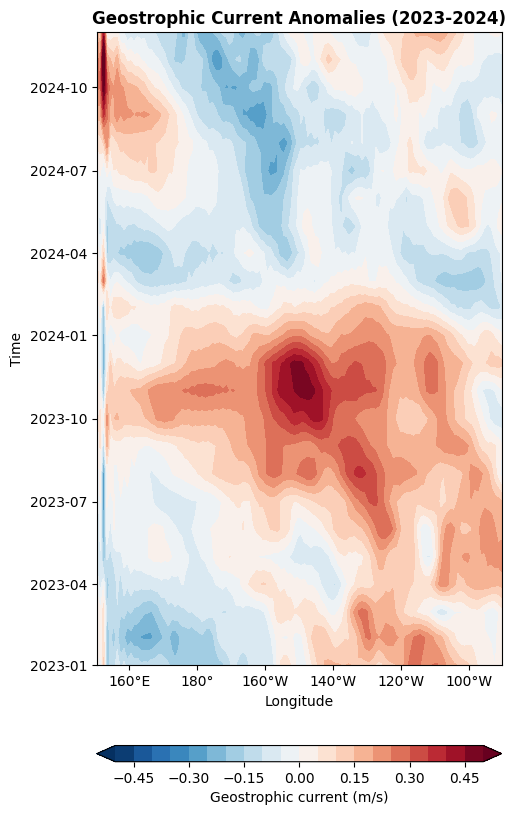

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import FuncFormatter

lon_format = lambda v, _: f'{abs(v-360):.0f}°W' if v > 180 else (f'{v:.0f}°E' if v < 180 else '180°')

time = ug['time'].values
lons = ug['lon'].values

factor = 100 
limit = 0.005 * factor
norm = TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)

cbarticks = np.arange(-limit, limit+0.05, 0.05)

cargs = dict(cmap='RdBu_r', levels=cbarticks, norm=norm, extend='both')

fig, ax = plt.subplots(figsize=(5, 8), constrained_layout=True)


hov = ug.sel(lat=slice(-5,5), lon=slice(150,280)).mean(dim='lat')
c = ax.contourf(lons, time, hov, **cargs)

ax.xaxis.set_major_formatter(FuncFormatter(lon_format))
ax.set_xlabel('Longitude')
ax.set_ylabel('Time')

cbar = fig.colorbar(c, ax=ax, orientation='horizontal', pad=0.05, aspect=25)
cbar.set_label('Geostrophic current (m/s)', fontsize=10)
ax.set_title('Geostrophic Current Anomalies (2023-2024)', fontweight='bold')

plt.show()

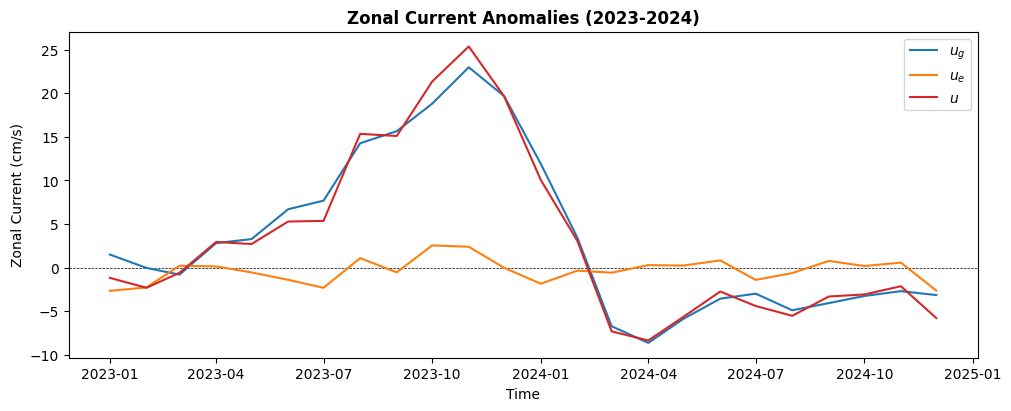

In [16]:
# Average Ekman current anomalies over the specified region

time = ue['time'].values
lons = ue['lon'].values

factor = 100 
avg_ug = ug.sel(lat=slice(-5,5), lon=slice(150,270)).mean(['lat', 'lon']) * factor
avg_ue = ue['u_e'].sel(lat=slice(-5,5), lon=slice(150,270)).mean(['lat', 'lon']) * factor

colors = ['tab:blue', 'tab:orange']

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

titles = [r'$u_g$', r'$u_e$']

for n, avg in enumerate([avg_ug, avg_ue]):
    ax.plot(time, avg, color=colors[n], label=titles[n])

combined_u = avg_ug + avg_ue
ax.plot(time, combined_u, color='tab:red', label='$u$')

ax.axhline(0, color='black', linestyle='--', linewidth=0.5, zorder=0)

ax.set_xlabel('Time')
ax.set_ylabel('Zonal Current (cm/s)')
ax.set_title('Zonal Current Anomalies (2023-2024)', fontweight='bold')

ax.legend()

plt.show()

# References
- Geng, X., Kug, JS., Shin, NY. et al. On the spatial double peak of the 2023–2024 El Niño event. Commun Earth Environ 5, 691 (2024). https://doi.org/10.1038/s43247-024-01870-1